# Sources of error in causal inference: Modeling, Identification and Estimation

To illustrate the different errors in a causal inference pipeline, we simulate three datasets. 

The dataset construction and analysis is taken from Sharma et al. (2021). [DoWhy: Addressing Challenges in Expressing and Validating Assumptions](https://arxiv.org/abs/2108.13518).

In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy.causal_estimators.linear_regression_estimator import LinearRegressionEstimator
from dowhy.causal_identifier import identify_effect
from dowhy.causal_graph import CausalGraph

# Avoid printing dataconversion warnings from sklearn
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import matplotlib.pyplot as plt
import seaborn as sns

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

In [2]:
NUM_SIMS = 100

## Data generation 

In [6]:
# Data-generating process for a causal graph with action and outcome, and a third variable
# that can either be a mediator (gen_data_m) or a confounder (gen_data_w)

from sklearn.linear_model import LinearRegression

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def gen_data_m(num_samples= 1000, p=0.95):
    """Generate data with a mediator. 
    
    :param num_samples: number of samples to generate
    :param p: Prob(Mediator=1|Action=1), and 1 - Prob(Mediator=1|Action=0).
    """
    beta=1
    # Action variable
    v0 = np.random.binomial(n=1, p=0.5,size=num_samples)
    # Independent gaussian error 
    eps = np.random.normal(0,1,num_samples)
    # Defining the generating function of mediator
    def m_func(v0):
        return np.where(v0==1, np.random.binomial(n=1, p=p, size=num_samples), 
                        np.random.binomial(n=1, p=1-p, size=num_samples))
    # Generating function for y. Does not depend on action directly.
    def y_func(v0, M0):
        y =(beta*10)* M0 + eps
        return y
    M0 = m_func(v0)
    y = y_func(v0, M0)
    
    # Calculate true causal effect
    ace = y_func(1, m_func(1)) - y_func(0, m_func(0))
    df= pd.DataFrame({"v0": v0, "y":y})
    df["M0"] = M0
    df.v0= df.v0.astype('bool')
    return df, np.mean(ace)

def gen_data_w(num_samples= 1000, p=0.95):
    """Generate dataset with a common cause confounder.
    
    :param num_samples: number of samples to generate
    :param p: Prob(Action=1|Confounder=1), and 1 - Prob(Action=1|Confounder=0).
    """
    beta=1
    # Confounder
    W0 = np.random.binomial(n=1, p=0.5,size=num_samples)
    # Independent gaussian noise
    eps = np.random.normal(0,1,num_samples)
    # Generating equation for the action variable
    v0 = np.where(W0==1, np.random.binomial(n=1, p=p, size=num_samples), np.random.binomial(n=1, p=1-p, size=num_samples))
    # Generating function for y, which depends on both v0 and W0.
    def y_func(v0):
        y =(beta)* v0 + beta*10*W0 + eps
        return y
    y = y_func(v0)
    
    # Calculate true causal effect
    ace = y_func(1) - y_func(0)
    # create df
    df= pd.DataFrame({"v0": v0, "y":y})
    df["W0"] = W0
    df.v0= df.v0.astype('bool')
    return df, np.mean(ace)

In [16]:
# Estimate the effect under different modeling (graph) assumptions

def effect(df, action, outcome, graph):
    """ Generic wrapper for effect estimation using DoWhy.
    """
    graph = CausalGraph(
        treatment_name=action,
        outcome_name=outcome,
        graph=graph,
        observed_node_names=df.columns.tolist()
    )
    identified_estimand = dowhy.identify_effect(graph, action, outcome)
    estimator = LinearRegressionEstimator(
        identified_estimand=identified_estimand,
        test_significance=None,
        evaluate_effect_strength=False
    ).fit(
        data=df,
        treatment_name=[action],
        outcome_name=outcome
    )

    estimate = estimator.estimate_effect(
        control_value=0,
        treatment_value=1,
        target_units="ate",
    )
    return estimate

naive_effects, true_effects, ace_arr = [], [], []
for i in range(NUM_SIMS):
    df, ace = gen_data_m()
    ace_arr.append(ace)
    # Data scientist does not know the true graph. Assumes that M0 is a confounder.
    #mod=LinearRegression().fit(df[["v0", "M0"]], df["y"])
    confounder_graph = "digraph{v0->y;M0->v0; M0->y}"
    mod = effect(df, "v0", "y", confounder_graph)
    naive_effects.append(mod.value)
    # Data scientist knows the true graph, where M0 is a mediator.
    mediator_graph = "digraph{v0->M0; M0->y}"
    mod = effect(df, "v0", "y", mediator_graph)
    true_effects.append(mod.value)
print("ANS")
print(np.mean(naive_effects), np.std(naive_effects))
print(np.mean(true_effects), np.std(true_effects))

ANS
-0.0066432014950412906 0.13053309606284244
8.974763884710878 0.16041888279445746


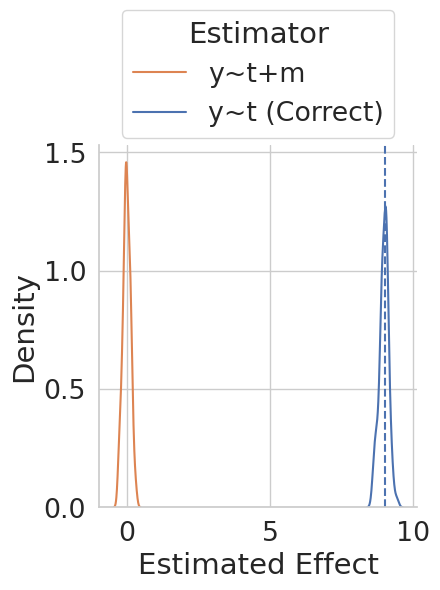

In [17]:
td = pd.DataFrame({'Estimated Effect':true_effects, 'Estimator': 'y~t (Correct)'})
nd = pd.DataFrame({'Estimated Effect':naive_effects, 'Estimator': "y~t+m"})
pltd = pd.concat([td,nd], axis=0)
sns.set(font_scale=1.75)
sns.set_style('whitegrid')
gfg= sns.displot(pltd, x="Estimated Effect", kind="kde", hue="Estimator", legend=False)
plt.legend(labels=["y~t+m", "y~t (Correct)"], bbox_to_anchor=(0.5, 1.02),
           borderaxespad=0, title="Estimator",
          loc="lower center")
plt.axvline(np.mean(ace_arr), linestyle="--")
plt.savefig("highbias-mediator.pdf",bbox_inches='tight')

In [21]:
# Data-generating process for a causal graph with action and outcome, and two other variables
# The two variables are an instrument (Z0) and a confounder (W0)

from sklearn.linear_model import LinearRegression

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def gen_data_iv(num_samples= 1000, p=0.95):
    beta=1
    Z0 = np.random.binomial(n=1, p=0.5,size=num_samples)
    eps = np.random.normal(0,100,num_samples)
    W0 = np.random.normal(0,0.4, size=num_samples)
    v0 = np.where(sigmoid(Z0*2-1+W0)>=0.5, 1, 0)
    def y_func(v0):
        y =(beta*10)* v0 + beta*10*W0 + eps
        return y
    y = y_func(v0)
    
    # Calculate causal effect
    ace = y_func(1) - y_func(0)
    df= pd.DataFrame({"v0": v0, "y":y})
    df["Z0"] = Z0
    df["W0"] = W0
    df.v0= df.v0.astype('bool')
    return df, np.mean(ace)


naive_effects, true_effects, ace_arr = [], [], []
for i in range(100):
    df, ace = gen_data_iv()
    ace_arr.append(ace)
    confounder_graph = "digraph{v0->y;Z0->v0; Z0->y; W0->v0; W0->y}"
    mod = effect(df, "v0", "y", confounder_graph)
    naive_effects.append(mod.value)
    #mod=LinearRegression().fit(df[["v0"]], df["y"])
    iv_graph = "digraph{v0->y;Z0->v0; W0->v0; W0->y}"
    mod = effect(df, "v0", "y", iv_graph)
    #print(mod.coef_[0], modnew.value)
    true_effects.append(mod.value)

print("ANS")
print(np.mean(naive_effects), np.std(naive_effects))
print(np.mean(true_effects), np.std(true_effects))


ANS
14.033530054977414 45.08157153957521
9.10250467016856 6.9169316056024375
[28.38581482]
            y   W0   vr
Z0 v0                  
0  False  496  496  496
   True     3    3    3
1  False    3    3    3
   True   498  498  498
              y        Z0        W0        vr
v0                                           
False  0.523363  0.006012  0.013873 -0.011396
True   4.237336  0.994012  0.036110  0.011351


In [ ]:
df, ace = gen_data_w()
print(df.head())
mod=LinearRegression().fit(df[["v0"]], df["y"])
print(mod.coef_)

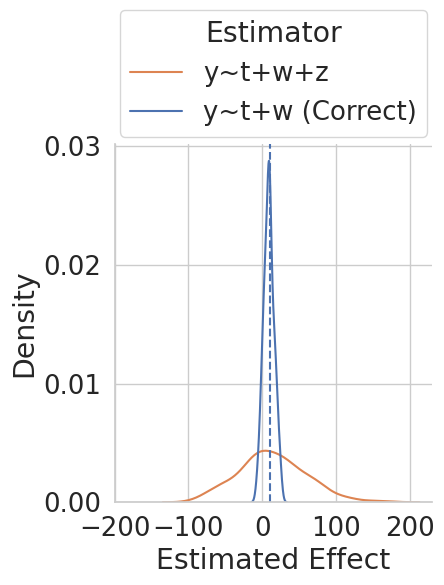

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
td = pd.DataFrame({'Estimated Effect':true_effects, 'Estimator': 'y~t+w (Correct)'})
nd = pd.DataFrame({'Estimated Effect':naive_effects, 'Estimator': "y~t+w+z"})
pltd = pd.concat([td,nd], axis=0)
sns.set(font_scale=1.7)
sns.set_style('whitegrid')
ax= sns.displot(pltd, x="Estimated Effect", kind="kde", hue="Estimator", legend=False)
plt.xticks([-200, -100, 0,100,200])
plt.legend(labels=["y~t+w+z", "y~t+w (Correct)"], bbox_to_anchor=(0.5, 1.02),
           borderaxespad=0, title="Estimator",
          loc="lower center")
#ax.set_xticklabels(labels=[0,10,20], step=50)
plt.axvline(np.mean(ace_arr), linestyle="--")
plt.savefig('highvariance-iv.pdf', bbox_inches="tight")